# Clustering

While clustering not necessarily classifies as a timeseries analysis tool, it is often in pre-processing steps alongside dimensionality reduction tools so that dynamical models can be fitted.

In the following, the different clustering methods available are shown at the example randomly generated dots on a 2D plane.

In [1]:
import matplotlib.pyplot as plt  # matplotlib for plotting
import numpy as np 
import sktime  # import the library

from sklearn.mixture import GaussianMixture  # for example data generation

rnd = np.random.RandomState(seed=17)  # create a random state with fixed seed for quasi-reproducibility

A Gaussian mixture model object is created with 13 components. The random state is fixed and the covariance type is set to `'diag'`, meaning that covariance matrices dscribing the model can only be diagonal matrices.

In [2]:
n_components = 5
gmm = GaussianMixture(n_components=n_components, random_state=rnd, covariance_type='diag')  # create a GMM object

The GMM is initialized so that all but one component have equal weight, the means $\mu$ are drawn randomly uniform $\mu\sim \mathcal{U}([-20, 20]^2)$, and the covariance matrix diagonals are drawn from $\mathcal{U}([15, 18]^2)$.

One component is set to a very high weight (relative to the others), so that most of the samples are drawn from its corresponding Gaussian.

In [3]:
gmm.weights_ = np.array([10., 10., 1000., 10., 10.])
gmm.weights_ /= gmm.weights_.sum()  # weights need to form a probability distribution
gmm.means_ = rnd.uniform(low=-20., high=20., size=(n_components, 2))  # centers are random uniform
gmm.covariances_ = rnd.uniform(low=15., high=18., size=(n_components, 2))  # same for covariance matrices

Samples are drawn and depicted in a heatmap. The color coding is on a logarithmic scale so that the under-populated states are visible too.

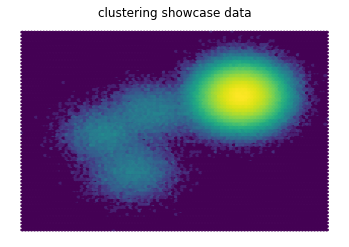

In [4]:
samples, labels = gmm.sample(1000000)  # generate data
plt.hexbin(*(samples.T), bins='log')
plt.axis('off')
plt.title('clustering showcase data');

## K-means

K-means clustering clusters the data in a way that minimizes the cost function

$$
C(S) = \sum_{i=1}^{k} \sum_{\mathbf{x}_j \in S_i} \left\| \mathbf{x}_j - \boldsymbol\mu_i \right\|^2,
$$

where $S_i$ are clusters with centers of mass $\mu_i$ and $\mathbf{x}_j$ data points associated to their clusters.

The outcome is very dependent on the initialization, in particular we offer "kmeans++" and "uniform". The latter
picks initial centers random-uniformly over the provided data set. The former tries to find an initialization
which is covering the spatial configuration of the dataset more or less uniformly.

### uniform initialization

Here, the initial set of centers $\hat\mu = \{mu_i : i=1,\ldots,k\}$ is determined by picking points from the dataset uniformly, i.e., 
$$
\hat\mu = \{\mathbf{x}_i : i = i_1,\ldots, i_k\},
$$
where $i_1,\ldots,i_k\sim \mathcal{U}\{1,\ldots,n_\mathrm{data}\}$.

To this end, we create a [KmeansClustering](../api/generated/sktime.clustering.KmeansClustering.rst#sktime.clustering.KmeansClustering) object. Note that that maximum number of iterations is set to zero so that the initialization can be observed.

In [5]:
estimator = sktime.clustering.KmeansClustering(
    n_clusters=100,  # place 100 cluster centers 
    init_strategy='uniform',  # uniform initialization strategy
    max_iter=0,  # don't actually perform the optimization, just place centers
    fixed_seed=13
)

In [6]:
clustering = estimator.fit(samples).fetch_model()

/home/mho/PycharmProjects/scikit-time/sktime/clustering/kmeans.py:387: UserWarning: Algorithm did not reach convergence criterion of 1e-05 in 0 iterations. Consider increasing max_iter.
  warnings.warn("Algorithm did not reach convergence criterion"


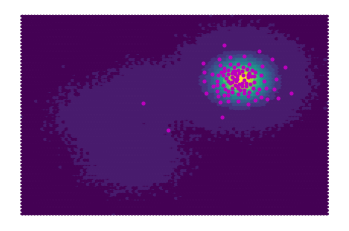

In [7]:
plt.hexbin(*(samples.T), bins=15)
plt.scatter(*(clustering.cluster_centers.T), marker='.', c='m')
plt.axis('off');

It becomes evident that almost all of the 100 cluster centers are placed in the area of the highly populated component. This can be a disadvantage when building [Markov state models](msm.ipynb), as here one would be interested in the transition between states and this clustering only resolves the highly populated state.

### k-means++ initialization

In [8]:
estimator = sktime.clustering.KmeansClustering(
    n_clusters=100,  # place 100 cluster centers
    init_strategy='kmeans++',  # uniform initialization strategy
    max_iter=0,  # don't actually perform the optimization, just place centers
    fixed_seed=13
)

In [9]:
clustering = estimator.fit(samples).fetch_model()

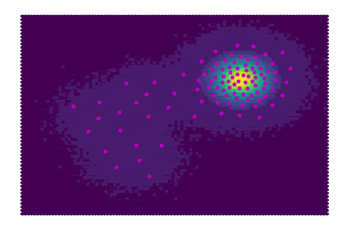

In [10]:
plt.hexbin(*(samples.T), bins=15)
plt.scatter(*(clustering.cluster_centers.T), marker='.', c='m')
plt.axis('off');